
=== Dropout Rate: 0.2 ===
Epoch 1, Loss: 34.1607
Epoch 2, Loss: 0.9479
Epoch 3, Loss: 0.2666
Epoch 4, Loss: 0.1149
Epoch 5, Loss: 0.0562


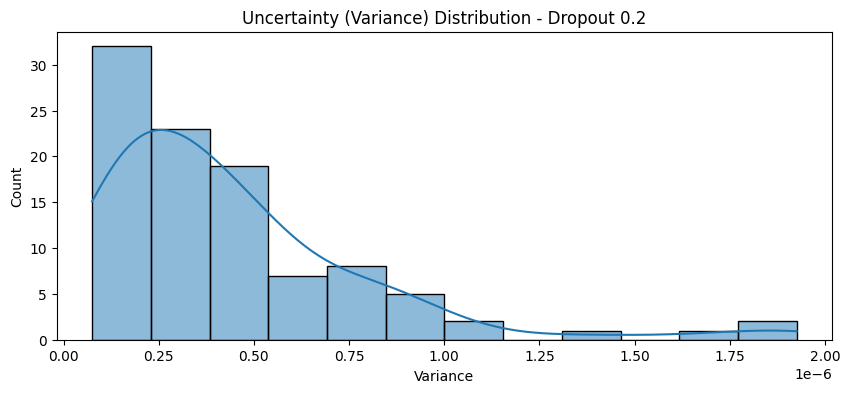

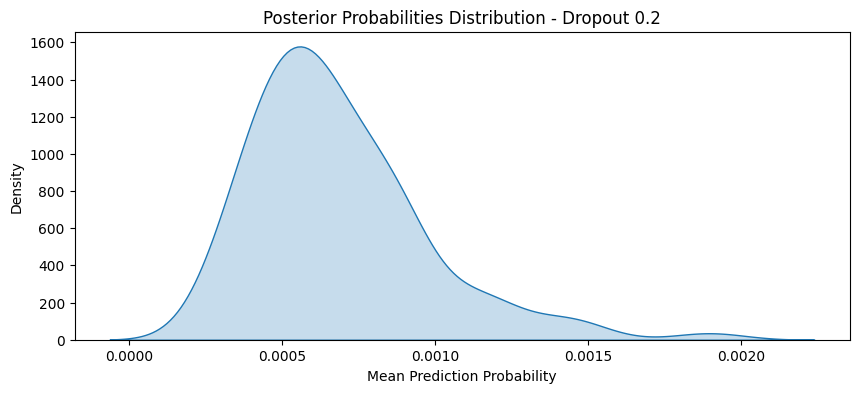


=== Dropout Rate: 0.4 ===
Epoch 1, Loss: 34.6674
Epoch 2, Loss: 1.1174
Epoch 3, Loss: 0.3335
Epoch 4, Loss: 0.1457
Epoch 5, Loss: 0.0751


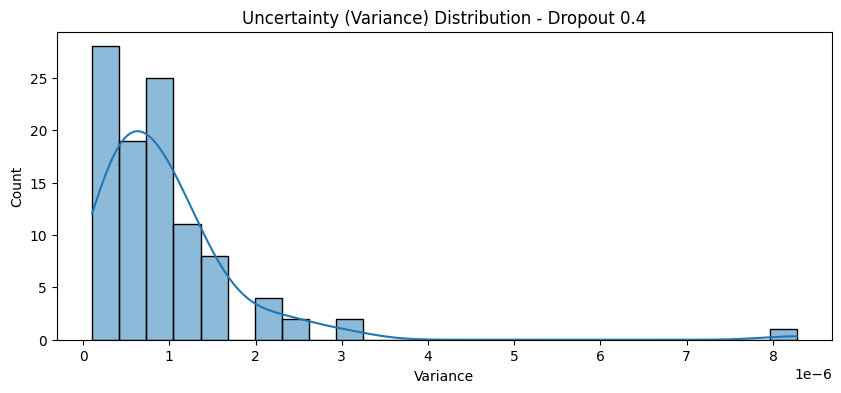

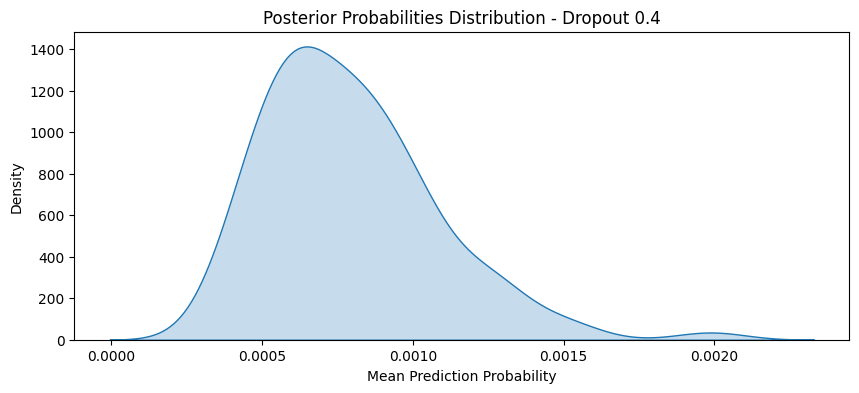


=== Dropout Rate: 0.6 ===
Epoch 1, Loss: 31.6179
Epoch 2, Loss: 1.1664
Epoch 3, Loss: 0.3497
Epoch 4, Loss: 0.1561
Epoch 5, Loss: 0.0801


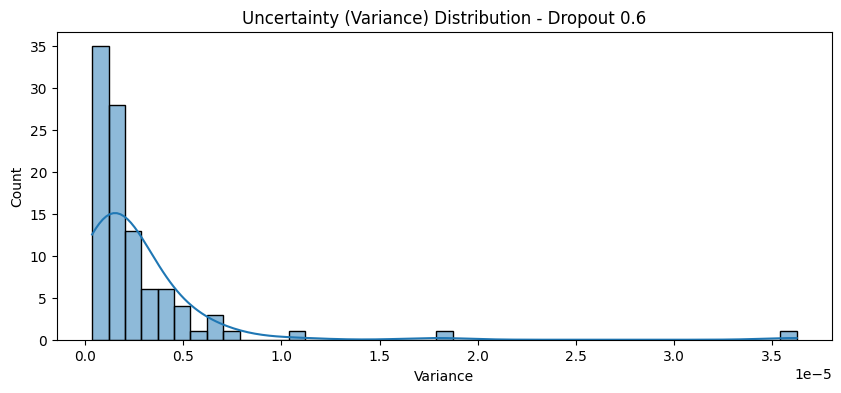

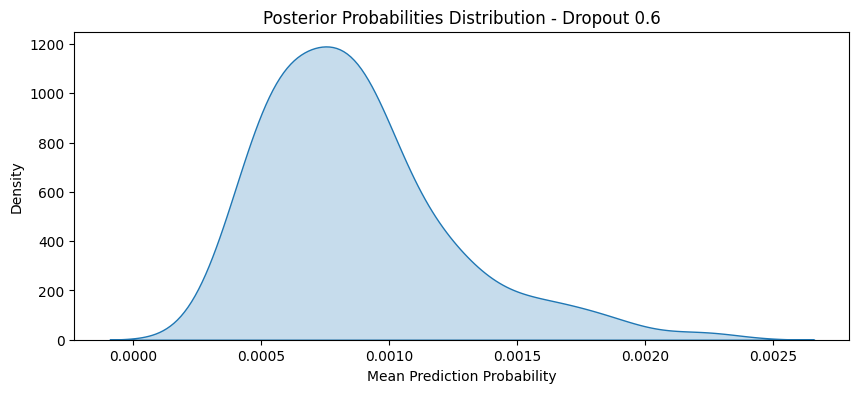

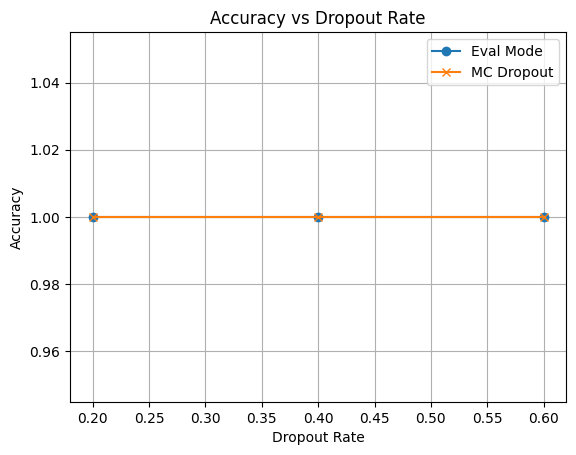

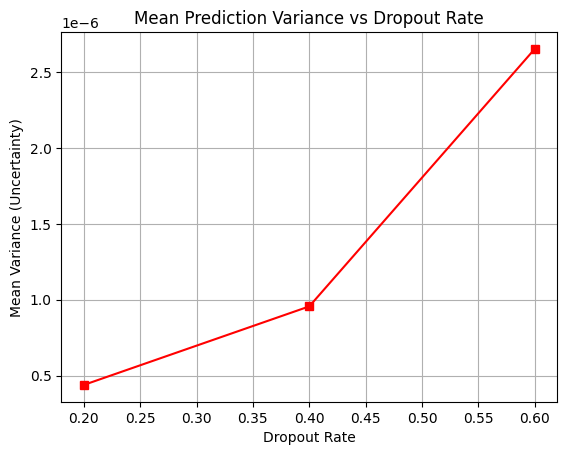

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Гиперпараметры
DROP_RATES = [0.2, 0.4, 0.6]
MC_PASSES = 100
BATCH_SIZE = 32
EMBED_DIM = 100
EPOCHS = 5

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Подготовка данных
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)

train_iter = IMDB(split='train')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == "pos" else 0

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(len(processed_text))
    text_list = nn.utils.rnn.pad_sequence(text_list, padding_value=0)
    return torch.tensor(label_list), text_list.T, torch.tensor(lengths)

train_iter, test_iter = IMDB()
train_dataloader = DataLoader(list(train_iter), batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = DataLoader(list(test_iter), batch_size=1, collate_fn=collate_batch)

# Модель
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, dropout_p):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = embedded.mean(dim=1)
        dropped = self.dropout(mean_emb)
        return torch.sigmoid(self.fc(dropped)).squeeze(1)

# Обучение
def train_model(model, dataloader, epochs=EPOCHS):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        total_loss = 0
        for labels, text, lengths in dataloader:
            labels, text = labels.to(device), text.to(device)
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Оценка без MC Dropout
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for labels, text, lengths in dataloader:
            output = model(text.to(device))
            pred = (output > 0.5).int().cpu()
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

# MC Dropout
def predict_mc(model, text, mc_passes=MC_PASSES):
    model.train() 
    preds = []
    for _ in range(mc_passes):
        with torch.no_grad():
            pred = model(text.to(device)).cpu().numpy()
            preds.append(pred)
    return np.array(preds)

# Оценка с MC Dropout
def evaluate_mc(model, dataloader, sample_size=100):
    model.train()
    correct = 0
    total = 0
    all_vars, all_means, all_labels = [], [], []

    for labels, text, lengths in list(dataloader)[:sample_size]:
        preds = predict_mc(model, text)
        pred_mean = preds.mean()
        pred_var = preds.var()
        pred_class = int(pred_mean > 0.5)

        all_means.append(pred_mean)
        all_vars.append(pred_var)
        all_labels.append(labels.item())

        correct += (pred_class == labels.item())
        total += 1

    accuracy = correct / total
    return accuracy, all_means, all_vars, all_labels

# Основной цикл
accuracies_std = []
accuracies_mc = []
mean_uncertainties = []

for drop in DROP_RATES:
    print(f"\n=== Dropout Rate: {drop} ===")
    model = TextClassifier(len(vocab), EMBED_DIM, drop).to(device)
    train_model(model, train_dataloader)
    acc_std = evaluate(model, test_dataloader)
    accuracies_std.append(acc_std)
    acc_mc, all_means, all_vars, all_labels = evaluate_mc(model, test_dataloader)
    accuracies_mc.append(acc_mc)
    mean_uncertainties.append(np.mean(all_vars))

    plt.figure(figsize=(10, 4))
    sns.histplot(all_vars, kde=True)
    plt.title(f"Uncertainty (Variance) Distribution - Dropout {drop}")
    plt.xlabel("Variance")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.kdeplot(all_means, fill=True)
    plt.title(f"Posterior Probabilities Distribution - Dropout {drop}")
    plt.xlabel("Mean Prediction Probability")
    plt.show()

# Графики анализа чувствительности
plt.figure()
plt.plot(DROP_RATES, accuracies_std, marker='o', label="Eval Mode")
plt.plot(DROP_RATES, accuracies_mc, marker='x', label="MC Dropout")
plt.title("Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(DROP_RATES, mean_uncertainties, marker='s', color='red')
plt.title("Mean Prediction Variance vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Mean Variance (Uncertainty)")
plt.grid(True)
plt.show()
